In [213]:
import pandas as pd
import numpy as np
import time
import re

from konlpy.tag import Mecab

from gensim.models import Word2Vec
mec = Mecab("C:/mecab/mecab-ko-dic")

In [214]:
path = "./물금고등학교-익명의-숲_진로편/"

df_cat = pd.read_csv(path + 'data/category.csv')
df_contents = pd.read_csv(path + 'contents.csv')

df_diag = pd.read_csv(path + 'data/diagnosis_ratio.csv')
df_diag.drop_duplicates(['이름'], inplace=True)

In [215]:
df_contents.dropna(inplace=True)
clean = re.compile(r'[^가-힣ㄱ-ㅎㅏ-ㅣ ]')
df_contents['content'] = df_contents['content'].apply(lambda x: clean.sub('', x))

df_contents['date'] = pd.to_datetime(df_contents['date'], format='%Y-%m-%d %H:%M')
weeks_all = [g for n, g in df_contents.set_index('date').groupby(pd.Grouper(freq='2W'))]

In [216]:
weeks = []
for week in weeks_all:
    week.drop(week[week['content'].apply(len) < 10].index, inplace=True)
    weeks.append(week.groupby('writer').agg({'content': ''.join}).reset_index())

In [217]:
# df_class = df_contents.groupby('writer').agg({'content': ''.join}).reset_index()

In [218]:
def Morph(df_class):
    list_morph = []
    for idx, (writer, content) in df_class[['writer', 'content']].iterrows():
        print(end='\r')
        print(idx + 1, "/", len(df_class), sep="", end='')
        morph_all = mec.pos(content)
        morph_all = pd.DataFrame(morph_all, columns=['word', 'part'])

        morph = morph_all[(morph_all['part'] == 'NNG') | (morph_all['part'] == 'NNG')]['word'].to_list()
        
        list_morph.append(morph)

    return list_morph

In [219]:
list_morphs = df_morphs['morph'].to_list()
w2vModel = Word2Vec(list_morphs, min_count=5)
w2vModel.wv.save_word2vec_format('model/similar')

In [220]:
# from gensim.models import keyedvectors
# from gensim.test.utils import datapath

# keyedvectors.load_word2vec_format('model/ko/ko.bin', encoding='ASCII')
# Word2Vec.load('./model/ko/ko.bin')

In [221]:
def CreateCat():
    type_sim_words = dict()
    for type_name, type_words in df_cat.iteritems():
        type_sim_words[type_name] = []
        for type_word in type_words:
            type_sim_words[type_name].extend([type_word])
            if not type_word in w2vModel.wv:
                continue
            
            type_sim_words[type_name].extend(np.array(w2vModel.wv.most_similar(type_word, topn=5))[:, 0])
        
        print(len(type_sim_words[type_name]), len(set(type_sim_words[type_name])))
        type_sim_words[type_name] = list(set(type_sim_words[type_name]))[:80]
    df_type = pd.DataFrame(type_sim_words, columns=df_cat.columns)
    df_type.to_csv(path + 'data/category_sim.csv', index=False)

In [222]:
def Count(df_morphs):
    list_count = []
    df_type = pd.read_csv(path + 'data/category_sim.csv')
    for idx, (writer, words) in df_morphs[['writer', 'morph']].iterrows():
        sTime = time.time()
        list_count.append([])
        for type_name, type_words in df_type.iteritems():
            count = 0
            for word in words:
                if word in w2vModel.wv:
                    sim_word = np.array(w2vModel.wv.most_similar(word, topn=3))[:, 0]
                    count += len(set(type_words) & set(sim_word))
                    
            list_count[-1].append(count)
        print('\r', idx+1, '/', len(df_morphs), '  time: ', time.time()-sTime,  sep='', end='')
        # print(writer, list_count[-1])
    
    return list_count

In [223]:
def Ratio(df_count):
    list_ratio = []
    for idx, (writer, count) in df_count[['writer', 'count']].iterrows():
        cntSum = sum(count)

        ratio = []
        for i in count:
            ratio.append(round(i / (cntSum+1) * 100, 2))
        list_ratio.append(ratio)

        # print(writer, ratio)
    return list_ratio
    df_ratio = df_count
    df_ratio['ratio'] = list_ratio

In [224]:
def Merge(df_ratio):
    df_diag.drop_duplicates(['이름'], inplace=True)

    list_merge = []
    for idx, (writer, ratio) in df_ratio[['writer', 'ratio']].iterrows(): #json 파일
        if not writer in df_diag['이름'].values:
            print('no diagnosis:', writer, ratio)
            df_ratio.drop(index=idx, axis=1, inplace=True)
            continue
        diag_data = df_diag[df_diag['이름'] == writer]

        data_ratio = diag_data['반영비율'].values[0]
        crawl_ratio = round(1 - data_ratio, 2)

        diag_ratio_adj = np.round(diag_data.iloc[:, 2:8].values * data_ratio, 2) #검사지 반영 비율 조절
        crawl_ratio_adj = np.round(np.array(ratio) * crawl_ratio, 2) #크롤링 반영 비율 조절
        
        merge_ratio = np.round(diag_ratio_adj + crawl_ratio_adj, 2)[0]

        list_merge.append(merge_ratio)
        # print(writer, data_ratio, end=": ")
        # print(diag_ratio_adj, crawl_ratio_adj, merge_ratio)

    return list_merge
    df_merge = df_ratio
    df_merge['merge'] = list_merge

In [225]:
def Change(df_merge):
    list_rateOfChange = []
    for idx, (writer, ratio, merge) in df_merge[['writer', 'ratio', 'merge']].iterrows(): #organizes json 파일
        list_rateOfChange.append(np.round((merge - ratio) / ratio * 100, 2))

    return list_rateOfChange
    df_rateOfChange = df_merge
    df_rateOfChange['change'] = list_rateOfChange

In [228]:
df_change = pd.DataFrame()
for i, week in enumerate(weeks):
    df = pd.DataFrame(week['writer'], columns=['writer'])
    df['morph'] = Morph(week)
    df['count'] = Count(df)
    df.drop(df[df['count'].apply(sum) < 100].index, inplace=True)
    df['ratio'] = Ratio(df)
    df['merge'] = Merge(df)
    df['change'] = Change(df)

    for idx, (writer, ratio) in df[['writer', 'merge']].iterrows():
        if not writer in df_change.columns:
            df_change[writer] = np.full(6, np.nan)
        df_change[writer][i] = ratio[0]

47/47  time: 0.012999773025512695no diagnosis: 서문아영 [16.03, 17.78, 18.37, 17.78, 15.45, 14.29]
no diagnosis: 영민 [15.75, 21.26, 16.54, 17.32, 14.17, 14.17]
82/82  time: 0.05799984931945801no diagnosis: 서문아영 [17.53, 17.97, 16.83, 16.89, 15.58, 15.18]
no diagnosis: 지현 [17.42, 18.76, 16.82, 18.16, 14.35, 14.42]
no diagnosis: 최지훈학생 [18.64, 17.64, 15.8, 16.59, 16.22, 15.07]
no diagnosis: 황보은별 [16.72, 18.18, 17.3, 17.6, 15.84, 14.08]
34/34  time: 0.0169985294342041no diagnosis: 서문아영 [17.76, 18.42, 17.17, 17.48, 14.85, 14.29]
no diagnosis: 지현 [15.72, 18.34, 17.47, 16.59, 15.28, 16.16]
no diagnosis: 최지훈학생 [18.05, 16.99, 15.82, 18.58, 16.56, 13.91]


C:\Users\Heoshin\miniconda3\envs\exhibition\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]


29/29  time: 0.07798624038696289no diagnosis: 서문아영 [16.53, 18.46, 16.8, 17.63, 15.29, 15.15]
no diagnosis: 지현 [16.67, 17.95, 17.74, 17.52, 14.96, 14.96]
19/19  time: 0.0299990177154541no diagnosis: 지현 [18.82, 18.82, 17.06, 14.71, 14.71, 15.29]
2/2  time: 0.035999298095703125no diagnosis: 지현 [17.39, 18.32, 18.79, 17.39, 14.29, 13.66]


In [256]:
df_change_sel = df_change.drop(df_change.columns[df_change.apply(lambda x: x.notnull().sum() < 4)], axis=1)
df_change_sel.fillna(method='ffill', inplace=True)
df_change_sel.fillna(method='bfill', inplace=True)

In [257]:
df_change_sel = df_change_sel - df_change_sel.shift()

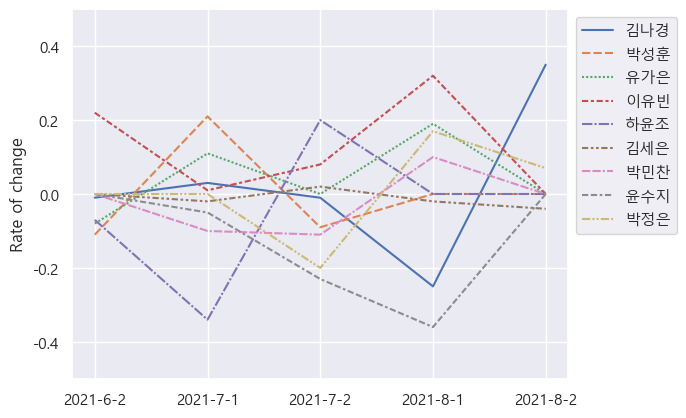

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
df_change_sel.index = ['2021-6-1', '2021-6-2', '2021-7-1', '2021-7-2', '2021-8-1', '2021-8-2']

sns.lineplot(data=df_change_sel)
plt.ylim((-0.5, 0.5))
plt.legend(loc = 2, bbox_to_anchor = (1,1))
plt.ylabel('Rate of change')
plt.savefig(path + 'all' + '.png')
plt.show()

,김나경,박성훈,유가은,이유빈,하윤조,김세은,박민찬,윤수지,박정은
2021-6-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-6-2,-0.01,-0.11,-0.08,0.22,-0.07,0.00,0.00,0.00,0.00
2021-7-1,0.03,0.21,0.11,0.01,-0.34,-0.02,-0.10,-0.05,0.00
2021-7-2,-0.01,-0.09,0.00,0.08,0.20,0.02,-0.11,-0.23,-0.20
2021-8-1,-0.25,0.00,0.19,0.32,0.00,-0.02,0.10,-0.36,0.17
2021-8-2,0.35,0.00,0.00,0.00,0.00,-0.04,0.00,0.00,0.07


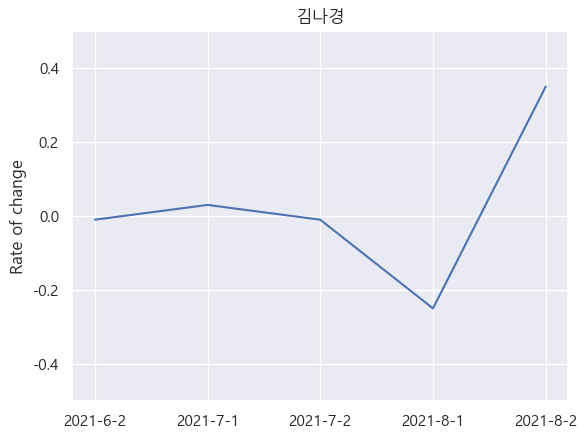

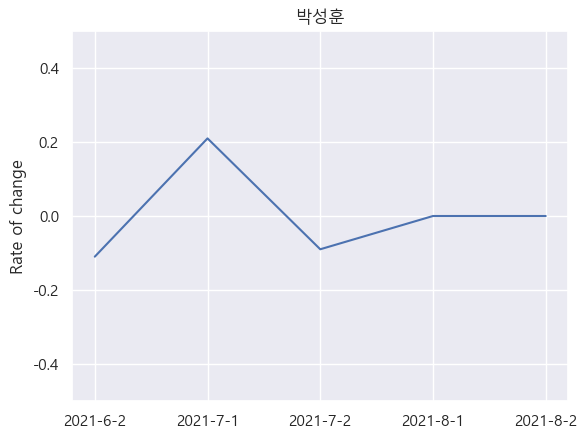

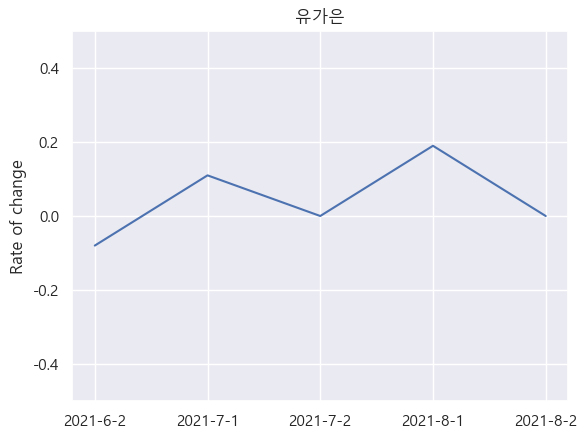

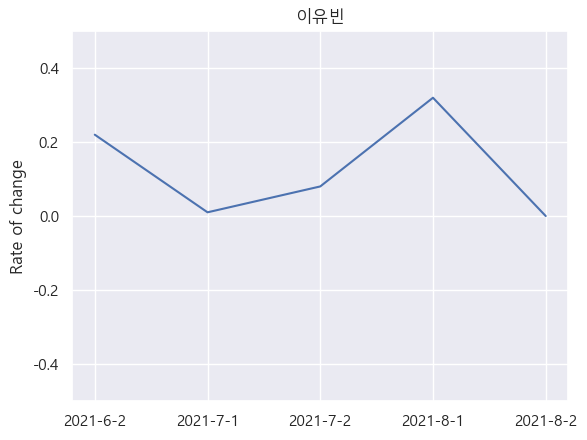

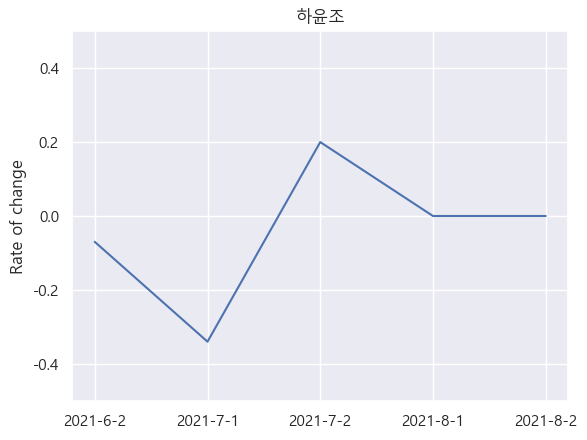

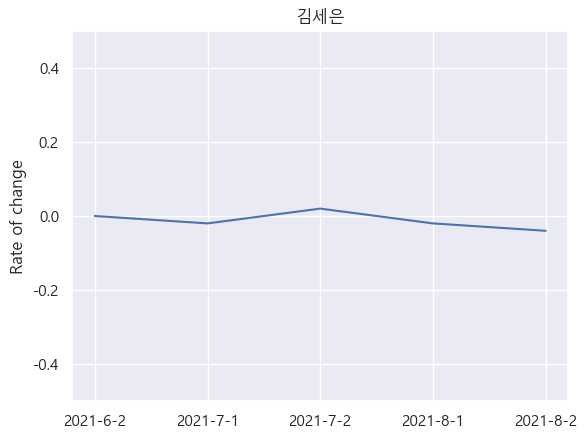

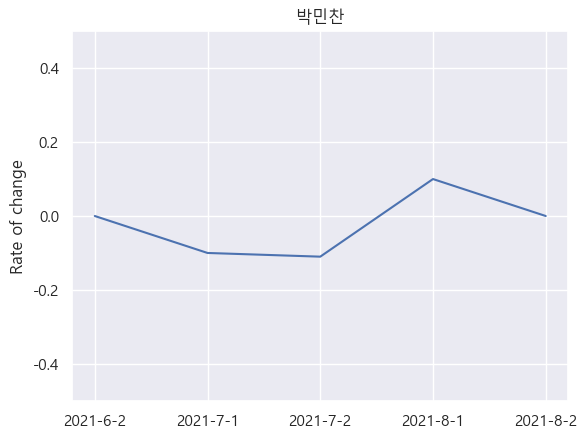

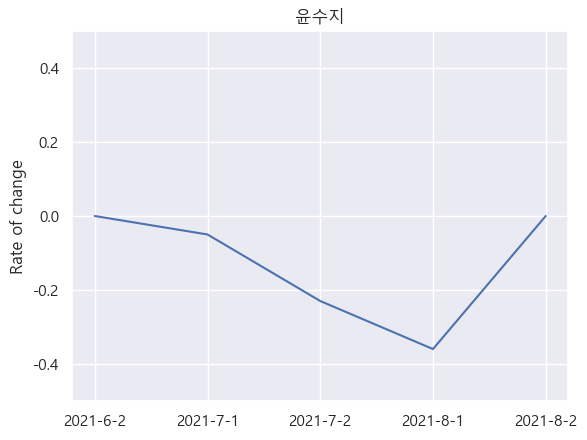

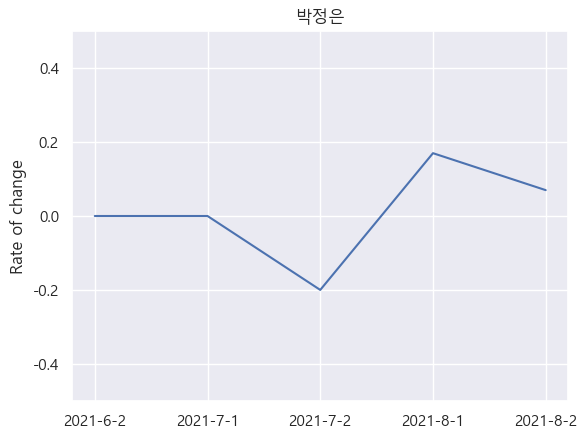

In [246]:
for col in df_change_sel:
        sns.lineplot(data=df_change_sel[col])
        plt.title(col)
        plt.ylabel('Rate of change')
        plt.ylim((-0.5, 0.5))
        
        plt.savefig(path + col + '.png')
        plt.show()

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

vocab = w2vModel.wv.key_to_index
similarity = w2vModel.wv[vocab]

trans_similarity = tsne.fit_transform(similarity)

df_tsne = pd.DataFrame(trans_similarity, index=vocab, columns=['x', 'y'])

C:\Users\Heoshin\miniconda3\envs\exhibition\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


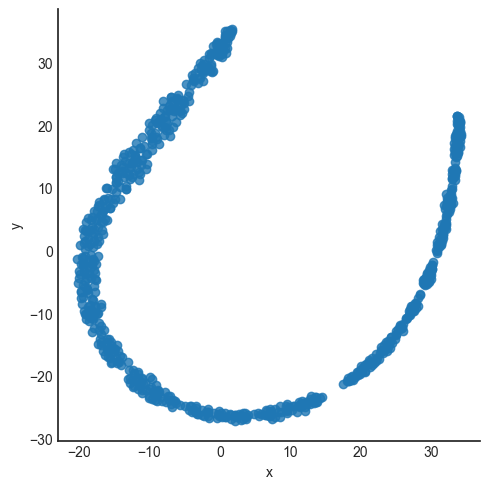

In [481]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-white')

sns.lmplot('x', 'y', data=df_tsne, fit_reg=False)
plt.savefig('visualization.png')
plt.show()